 # Libraries with fixed versions and data loading

In [1]:
# %pip install xgboost==1.6.2
# %pip install shap==0.41.0
# %pip install pandas==1.3.5
# %pip install plotly==5.10.0
# %pip install scikit-learn==1.0.2
# %pip install seaborn
# %pip install graphviz
# %pip install wheel
# %pip install sklearn
# %pip install glmnet


In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics


In [3]:
# # Enable export of plotly interactivity in html export
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected = True)


 To load the data, you can simply put it on Google Drive and read it in a few lines of code (there are multiple other ways to do it).

 For speed, we can load only the provided 26 columns (1 target, 1 ID and 24 features).

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')


In [5]:
ap_train = pd.read_csv('Data/CSV/application_train.csv',
                    usecols =  ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
                                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                                'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
                                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 
                                'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 
                                'EXT_SOURCE_2', 'EXT_SOURCE_3'])
print(f"Application train dataset shape: {ap_train.shape}")


Application train dataset shape: (307511, 26)


 For simplicity, we'll create a AGE (in years) variable from DAYS_BIRTH (in days).

In [6]:
ap_train['AGE'] = -round(ap_train['DAYS_BIRTH']/365)
ap_train.drop(columns='DAYS_BIRTH', inplace=True)


 # **[#1] Interesting variables**

In [7]:
int_cols = ["CODE_GENDER", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "AGE"]


 # **[#2] Interesting variables with respect to target**

In [8]:
ap_train.dtypes


SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
OCCUPATION_TYPE                object
EXT_SOURCE_1                  float64
EXT_SOURCE_2                  float64
EXT_SOURCE_3                  float64
AGE                           float64
dtype: objec

In [9]:
ap_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  307511 non-null  int64  
 1   TARGET                      307511 non-null  int64  
 2   NAME_CONTRACT_TYPE          307511 non-null  object 
 3   CODE_GENDER                 307511 non-null  object 
 4   FLAG_OWN_CAR                307511 non-null  object 
 5   FLAG_OWN_REALTY             307511 non-null  object 
 6   CNT_CHILDREN                307511 non-null  int64  
 7   AMT_INCOME_TOTAL            307511 non-null  float64
 8   AMT_CREDIT                  307511 non-null  float64
 9   AMT_ANNUITY                 307499 non-null  float64
 10  AMT_GOODS_PRICE             307233 non-null  float64
 11  NAME_TYPE_SUITE             306219 non-null  object 
 12  NAME_INCOME_TYPE            307511 non-null  object 
 13  NAME_EDUCATION

In [10]:
ap_train.describe()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,134133.000000,3.068510e+05,246546.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,63815.045904,-4986.120328,-2994.202373,12.061091,0.502130,5.143927e-01,0.510853,43.938646
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,141275.766519,3522.886321,1509.450419,11.944812,0.211062,1.910602e-01,0.194844,11.964047
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-17912.000000,-24672.000000,-7197.000000,0.000000,0.014568,8.173617e-08,0.000527,21.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-2760.000000,-7479.500000,-4299.000000,5.000000,0.334007,3.924574e-01,0.370650,34.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-1213.000000,-4504.000000,-3254.000000,9.000000,0.505998,5.659614e-01,0.535276,43.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-289.000000,-2010.000000,-1720.000000,15.000000,0.675053,6.636171e-01,0.669057,54.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,365243.000000,0.000000,0.000000,91.000000,0.962693,8.549997e-01,0.896010,69.000000


In [11]:
int_cols_con = []
int_cols_cat = []

for col in int_cols:
    if ap_train[col].dtype == object:
        int_cols_cat.append(col)
    else:
        int_cols_con.append(col)


In [12]:
int_cols_con


['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE']

In [13]:
int_cols_cat


['CODE_GENDER',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']

In [14]:
df_binned = pd.DataFrame()
df_binned["TARGET"] = ap_train["TARGET"]
for col in int_cols:
    df_binned[col] = ap_train[col]

df_binned = df_binned[df_binned.CODE_GENDER != "XNA"]


In [15]:
print(df_binned.shape)


(307507, 9)


In [16]:
def cap_data(dati, col_list):
    for col in col_list:
        print("capping the ",col)
        if (((dati[col].dtype)=='float64') | ((dati[col].dtype)=='int64')):
            percentiles = dati[col].quantile([0.01,0.99]).values
            dati[col][dati[col] <= percentiles[0]] = percentiles[0]
            dati[col][dati[col] >= percentiles[1]] = percentiles[1]
        else:
            dati[col]=dati[col]
    return dati

df_binned=cap_data(df_binned, int_cols_con)


capping the  CNT_CHILDREN
capping the  AMT_INCOME_TOTAL
capping the  AGE



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
df_binned.shape


(307507, 9)

In [18]:
for col in int_cols_con:
    df_binned[col] = pd.cut(df_binned[col], 6, precision=0)


In [19]:
df_binned["CNT_CHILDREN"].describe()


count            307507
unique                4
top       (-0.003, 0.5]
freq             215369
Name: CNT_CHILDREN, dtype: object

In [20]:
df_binned["AMT_INCOME_TOTAL"]


0         (187500.0, 258750.0]
1         (258750.0, 330000.0]
2          (44572.0, 116250.0]
3         (116250.0, 187500.0]
4         (116250.0, 187500.0]
                  ...         
307506    (116250.0, 187500.0]
307507     (44572.0, 116250.0]
307508    (116250.0, 187500.0]
307509    (116250.0, 187500.0]
307510    (116250.0, 187500.0]
Name: AMT_INCOME_TOTAL, Length: 307507, dtype: category
Categories (6, interval[float64, right]): [(44572.0, 116250.0] < (116250.0, 187500.0] < (187500.0, 258750.0] < (258750.0, 330000.0] < (330000.0, 401250.0] < (401250.0, 472500.0]]

In [21]:
df_binned["TARGET"].describe()


count    307507.00000
mean          0.08073
std           0.27242
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max           1.00000
Name: TARGET, dtype: float64

In [22]:
import os

outpath = 'Plots'

# Check whether the specified path exists or not
isExist = os.path.exists(outpath)

if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(outpath)
  print("The new directory is created!")

os.chdir(outpath)


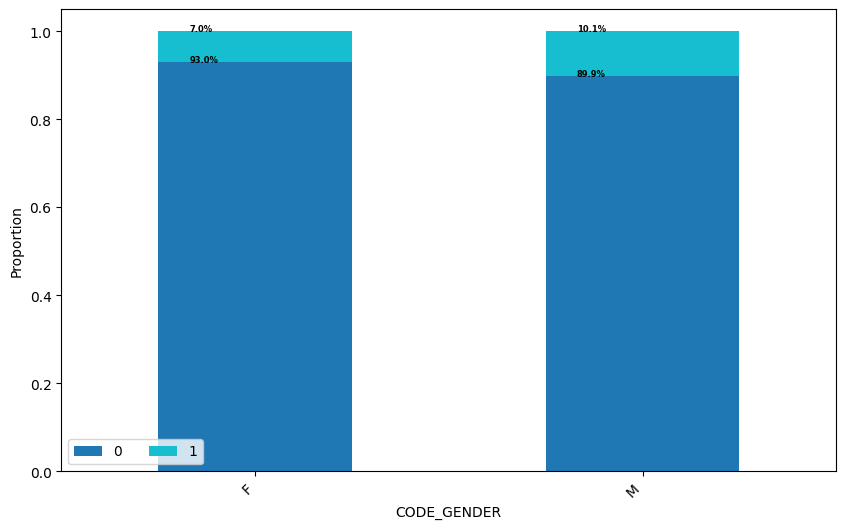

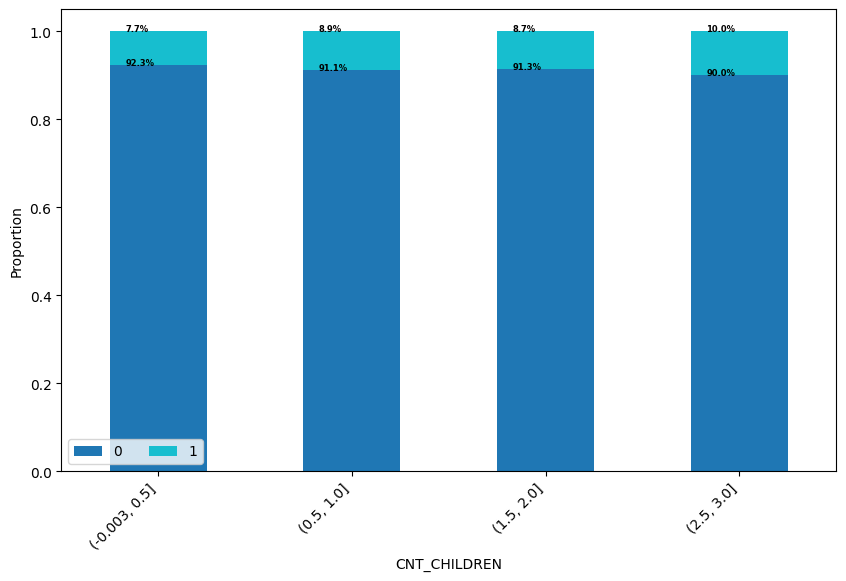

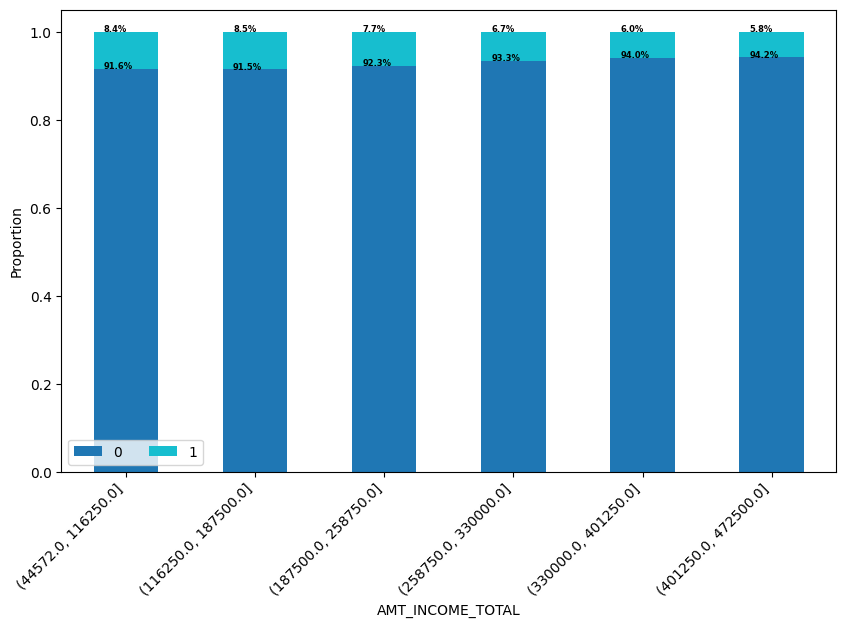

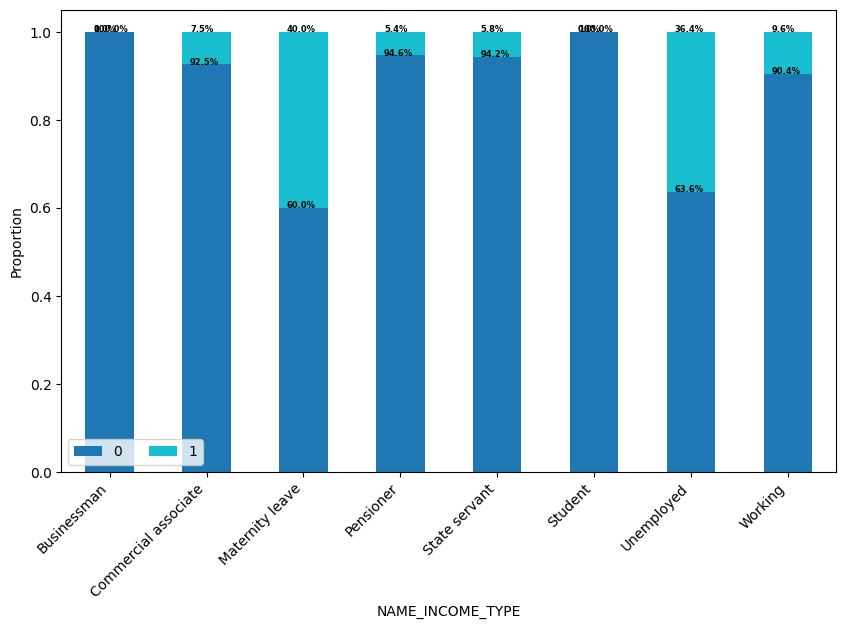

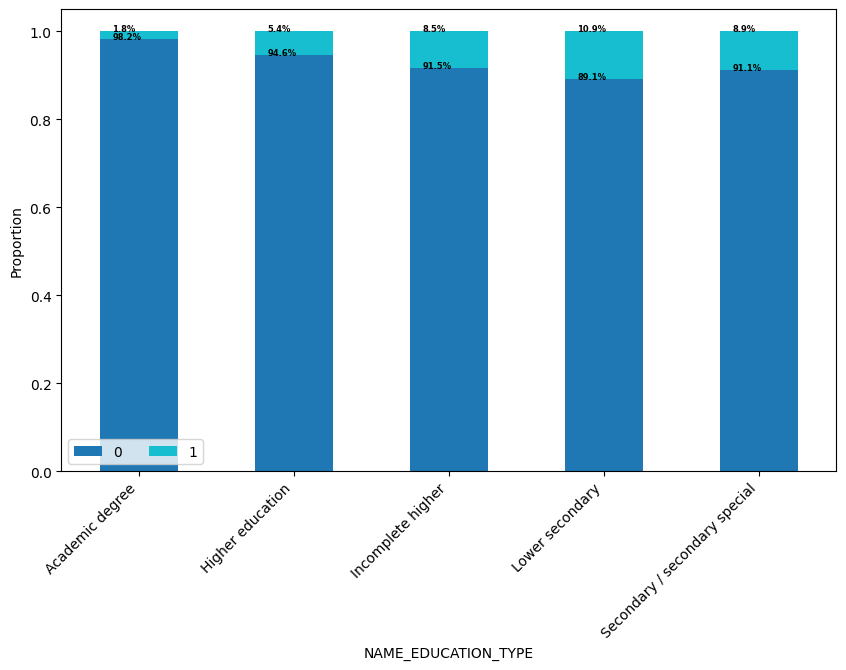

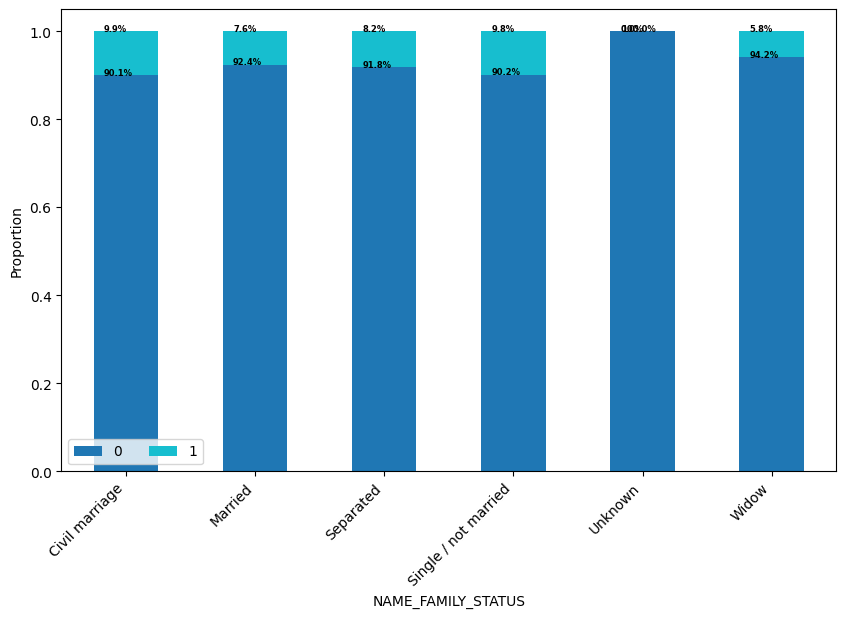

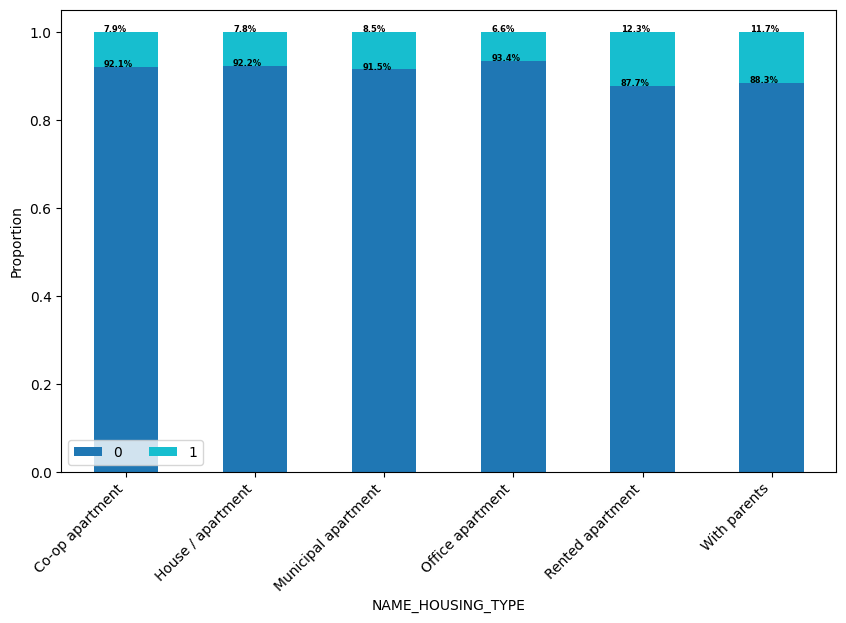

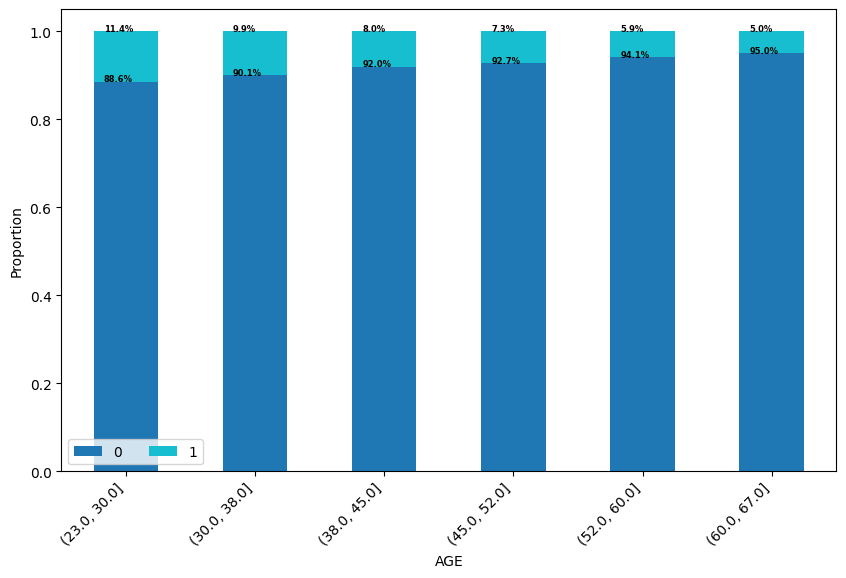

In [23]:
import matplotlib.pyplot as plt



for col in int_cols:
    cross_tab_prop = pd.crosstab(index=df_binned[col],
                            columns=df_binned["TARGET"],
                                normalize="index")
    cross_tab_prop

    cross_tab = pd.crosstab(index=df_binned[col],
                            columns=df_binned["TARGET"])
    cross_tab

    cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6))

    plt.legend(loc="lower left", ncol=2)
    plt.xlabel(str(col))
    plt.ylabel("Proportion")
    plt.xticks(rotation=45, ha='right')


    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                    cross_tab_prop.loc[x].cumsum()):
                    
            plt.text(x=n - 0.17,
                    y=y_loc,
                    s=f'{np.round(proportion * 100, 1)}%', 
                    color="black",
                    fontsize=6,
                    fontweight="bold")

    plt.savefig("ORIGINAL_" + str(col), bbox_inches = "tight")
    plt.show()


 # Preparing the data

 Let's prepare the data for a simple ML model.

 First of all, feature encoding.

In [24]:
ap_train_unbiased = ap_train.copy(deep = True)

In [25]:
ap_train['CODE_GENDER_M'] = np.select([ap_train['CODE_GENDER'] == 'M', ap_train['CODE_GENDER'] == 'F'], [1, 0], default=np.NaN)
ap_train['FLAG_OWN_CAR'] = np.where(ap_train['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train['FLAG_OWN_REALTY'] = np.where(ap_train['FLAG_OWN_REALTY'] == 'Y', 1, 0)
ap_train.drop(columns='CODE_GENDER', inplace=True)

In [26]:
ap_objects = list(ap_train.select_dtypes(include=['object']).columns)
ap_train[ap_objects] = ap_train[ap_objects].astype('category')

 Let's separate the target from the rest of the data

In [27]:
ap_train_target = ap_train.pop('TARGET')
print(f"Target dataset shape: {ap_train_target.shape}")

Target dataset shape: (307511,)


 Let's split the original dataset in two:

 *   80% for the train dataset
 *   20% for the test one



In [28]:
df_train, df_test, df_target_train, df_target_test = train_test_split(
    ap_train, ap_train_target, test_size=0.2, stratify=ap_train_target, random_state=42)

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")


Train dataset shape: (246008, 25)
Test dataset shape: (61503, 25)


In [29]:
df_train.dtypes


SK_ID_CURR                       int64
NAME_CONTRACT_TYPE            category
FLAG_OWN_CAR                     int32
FLAG_OWN_REALTY                  int32
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE               category
NAME_INCOME_TYPE              category
NAME_EDUCATION_TYPE           category
NAME_FAMILY_STATUS            category
NAME_HOUSING_TYPE             category
REGION_POPULATION_RELATIVE     float64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
OCCUPATION_TYPE               category
EXT_SOURCE_1                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_3                   float64
AGE                            float64
CODE_GENDER_M                  float64
dtype: object

In [30]:
cat_cols = []
for col in df_train.columns:
    if df_train[col].dtype == "category":
        cat_cols.append(col)
cat_cols


['NAME_CONTRACT_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE']

In [31]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()

for col in cat_cols:
    df_train[col] = lbl.fit_transform(df_train[col].astype(str))


 # Create a basic ML model and scoring on the test set

 I'll train a simple XGBoost model (parameters previously chosen with cross-validation).

In [32]:
df_train_dmatrix = xgb.DMatrix(df_train.drop(columns='SK_ID_CURR'), label = df_target_train, enable_categorical=True)

param = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model = xgb.train(param, df_train_dmatrix, num_boost_round=50)


 Let's score the test set.

In [33]:
df_test_dmatrix = xgb.DMatrix(df_test.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results = xgb_base_model.predict(df_test_dmatrix)


 What are the risk scores (from 0 to 1) of the first 5 customers in the test set? And what's the overall AUC on the test set?

In [34]:
xgb_base_test_results[:5]


array([0.412908  , 0.3104497 , 0.7822344 , 0.27786046, 0.47344765],
      dtype=float32)

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test, xgb_base_test_results, pos_label=1)
metrics.auc(fpr, tpr)


0.7533808950317153

 The third customer has a higher risk score (0.796) than the others in the first 5 records.

 This simple model has an AUC on the test set around **0.754**, a decent baseline performance.

 # **[#3] Evaluating feature importance**

In [36]:
xgb_base_model.get_fscore()


{'NAME_CONTRACT_TYPE': 24.0,
 'FLAG_OWN_CAR': 6.0,
 'FLAG_OWN_REALTY': 15.0,
 'CNT_CHILDREN': 20.0,
 'AMT_INCOME_TOTAL': 127.0,
 'AMT_CREDIT': 192.0,
 'AMT_ANNUITY': 204.0,
 'AMT_GOODS_PRICE': 135.0,
 'NAME_TYPE_SUITE': 22.0,
 'NAME_INCOME_TYPE': 22.0,
 'NAME_EDUCATION_TYPE': 40.0,
 'NAME_FAMILY_STATUS': 36.0,
 'NAME_HOUSING_TYPE': 19.0,
 'REGION_POPULATION_RELATIVE': 114.0,
 'DAYS_EMPLOYED': 176.0,
 'DAYS_REGISTRATION': 173.0,
 'DAYS_ID_PUBLISH': 196.0,
 'OWN_CAR_AGE': 105.0,
 'OCCUPATION_TYPE': 48.0,
 'EXT_SOURCE_1': 287.0,
 'EXT_SOURCE_2': 261.0,
 'EXT_SOURCE_3': 255.0,
 'AGE': 153.0,
 'CODE_GENDER_M': 37.0}

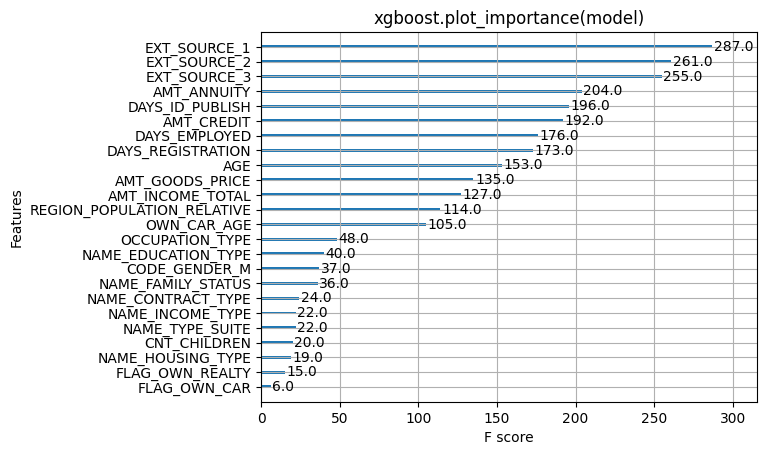

In [37]:
xgb.plot_importance(xgb_base_model)
plt.title("xgboost.plot_importance(model)")
plt.show()


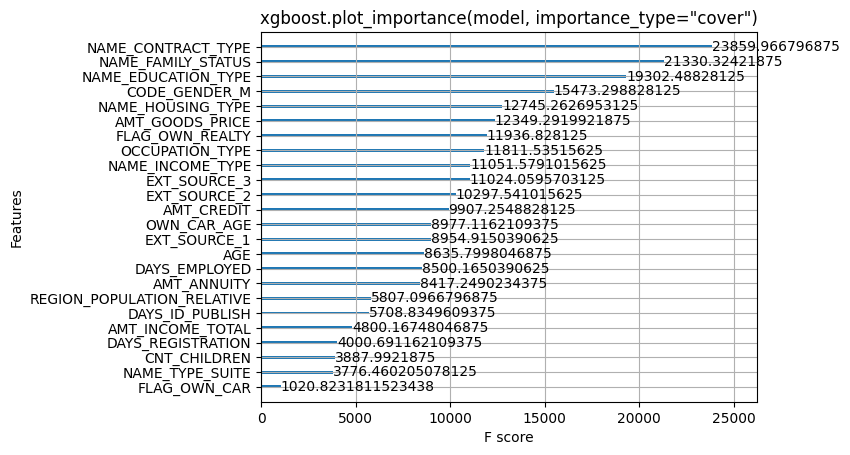

In [38]:
xgb.plot_importance(xgb_base_model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()


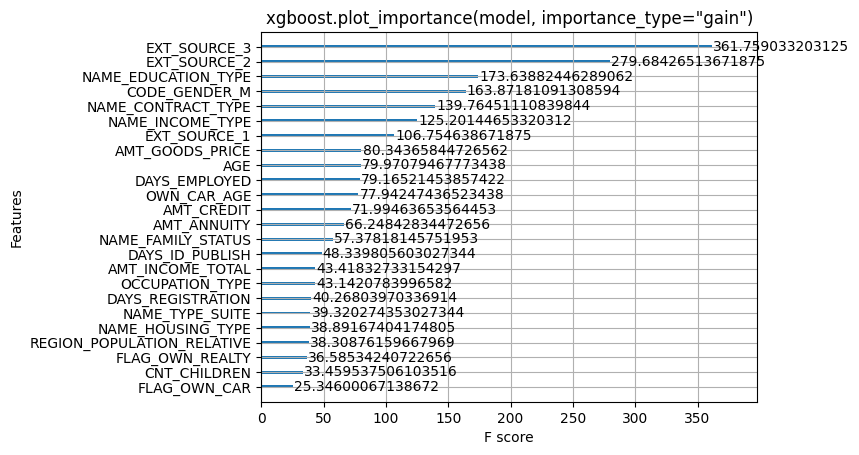

In [39]:
xgb.plot_importance(xgb_base_model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()


In [40]:
explainer = shap.Explainer(xgb_base_model)
shap_values = explainer.shap_values(df_train.drop(columns='SK_ID_CURR'))


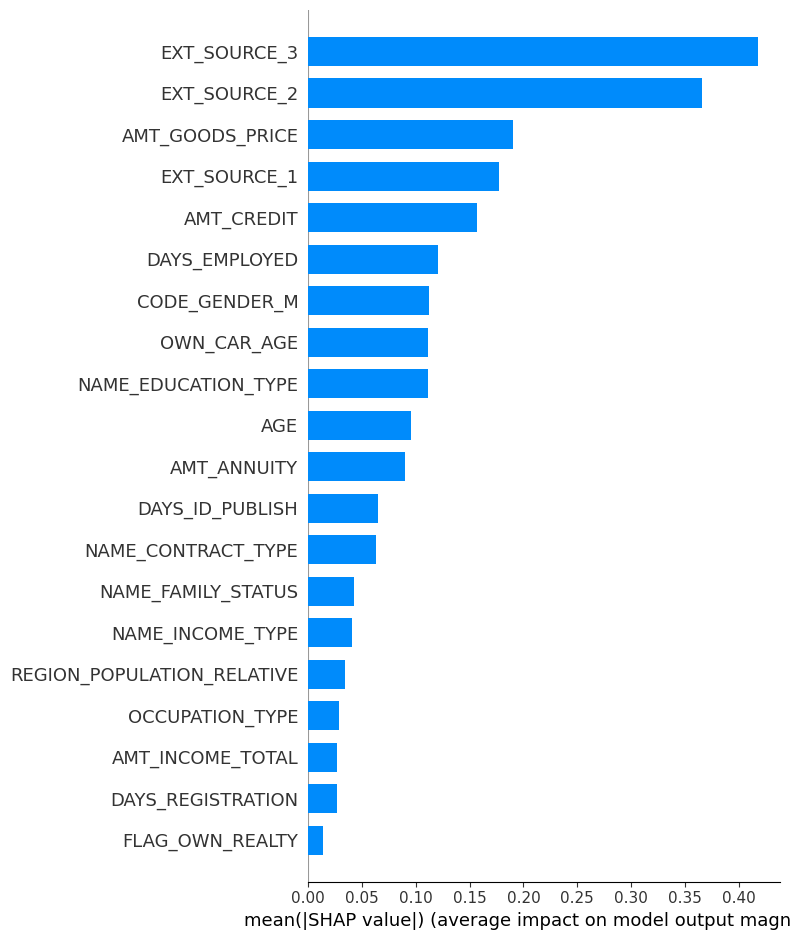

In [41]:
shap.summary_plot(shap_values, ap_train.drop(columns='SK_ID_CURR'), plot_type="bar")


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


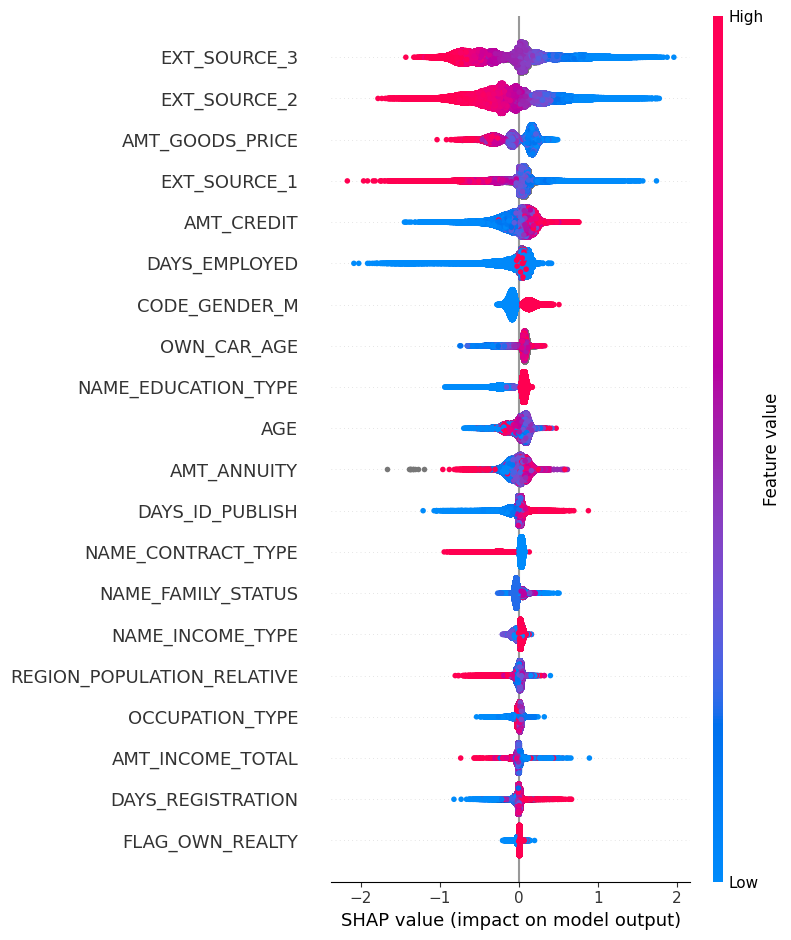

In [42]:
shap.summary_plot(shap_values, df_train.drop(columns='SK_ID_CURR'))


 Feature importance: Variables are ranked in descending order.
 Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
 Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
 Correlation: A high level of "EXT_SOURCE" has a high and negative impact on the target. The “high” comes from the red color, and the "negative” impact is shown on the X-axis.

 # **[#4] Comparing the model predictions with respect to the original training data**

In [43]:
xgb_base_test_results.shape


(61503,)

In [44]:
df_test.drop(columns='SK_ID_CURR').shape


(61503, 24)

In [45]:
df_test.drop(columns='SK_ID_CURR').columns


Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'AGE', 'CODE_GENDER_M'],
      dtype='object')

In [46]:
int_cols_cat


['CODE_GENDER',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']

In [47]:
int_cols_cat_test = []
for col in int_cols_cat:
    check = col
    res = [i for i in df_test.drop(columns='SK_ID_CURR').columns if check in i]
    int_cols_cat_test += res


In [48]:
df_test_binned=cap_data(df_test.drop(columns='SK_ID_CURR'), int_cols_con)


capping the  CNT_CHILDREN
capping the  AMT_INCOME_TOTAL
capping the  AGE



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
for col in int_cols_con:
    df_test_binned[col] = pd.cut(df_test_binned[col], 6, precision=0)



In [50]:
int_cols_test = int_cols_con + int_cols_cat_test


In [51]:
int_cols_test


['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AGE',
 'CODE_GENDER_M',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']

In [52]:
from sklearn.metrics import accuracy_score
predictions = [round(value) for value in xgb_base_test_results]
accuracy = accuracy_score(df_target_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))


Accuracy: 74.70%


In [53]:
df_test_binned["TARGET"] = predictions


In [54]:
df_test_binned.shape


(61503, 25)

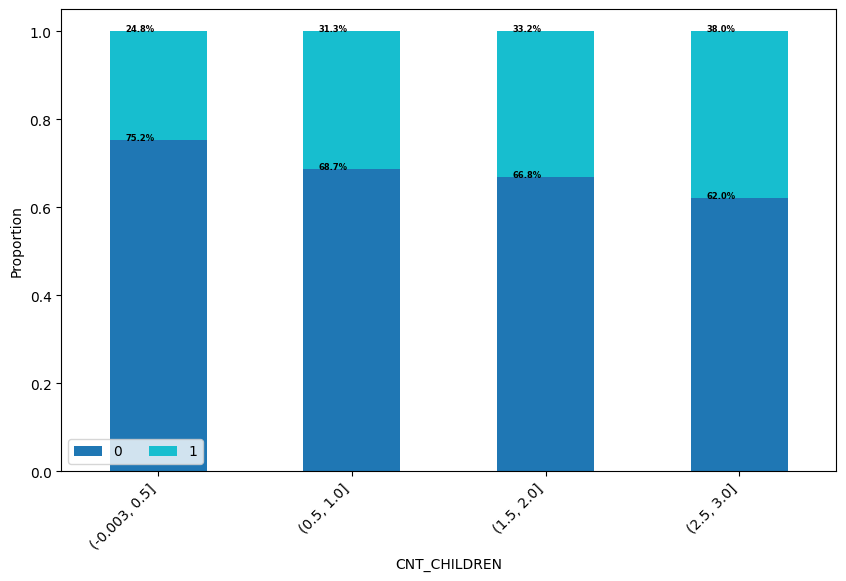

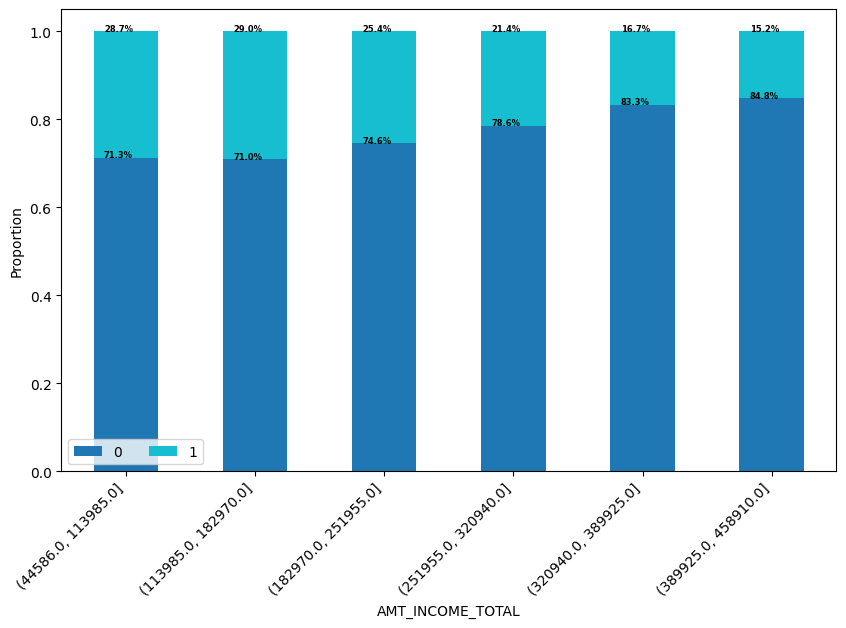

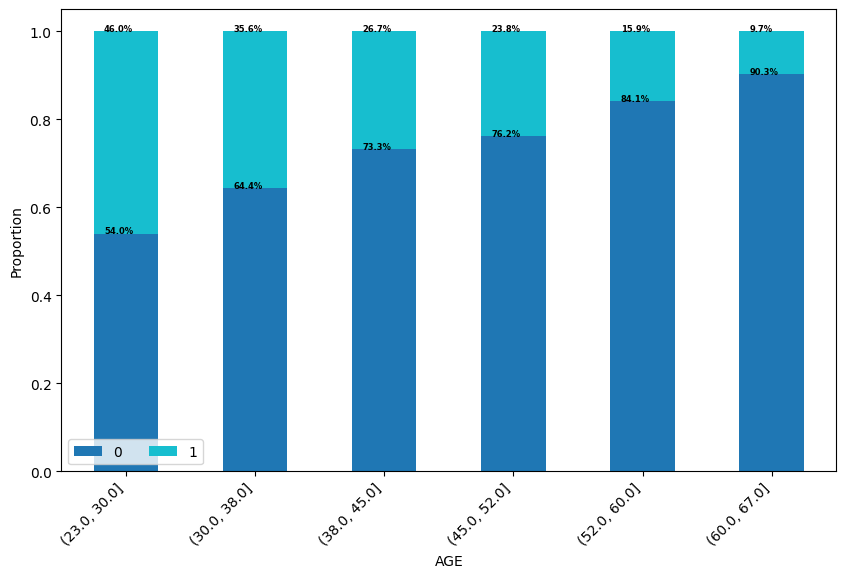

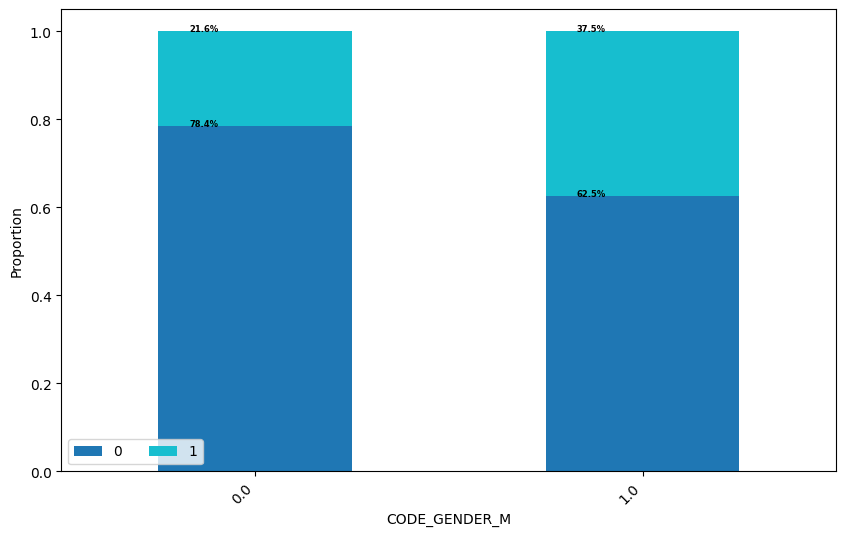

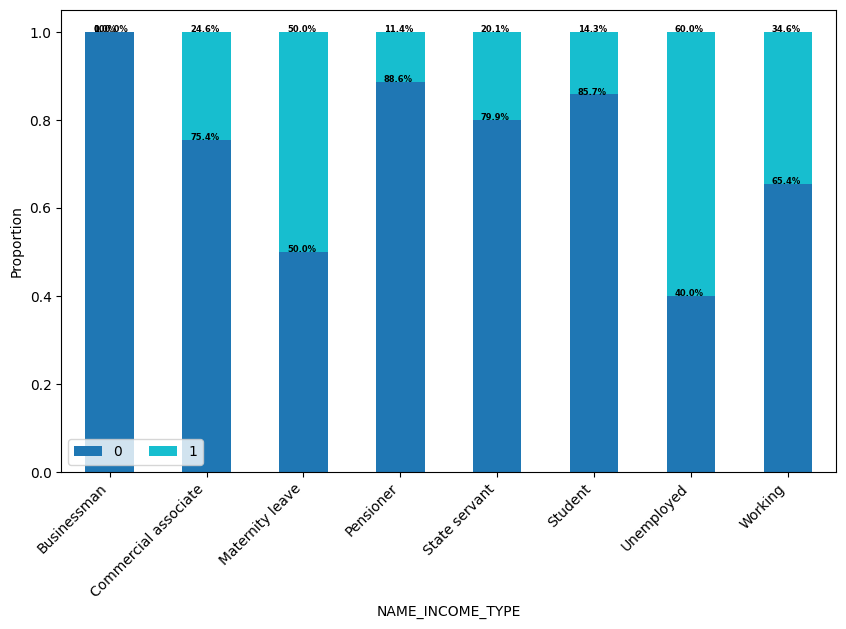

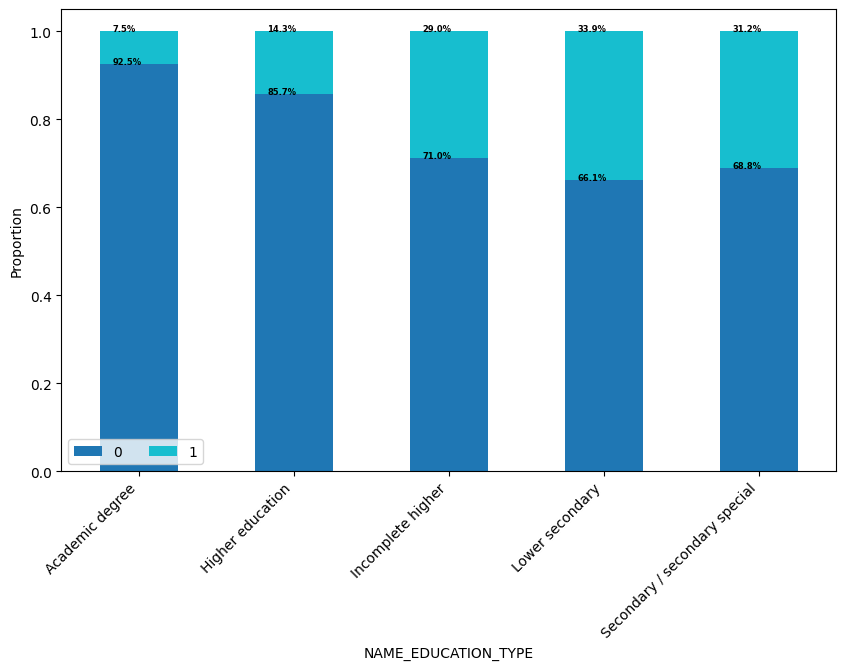

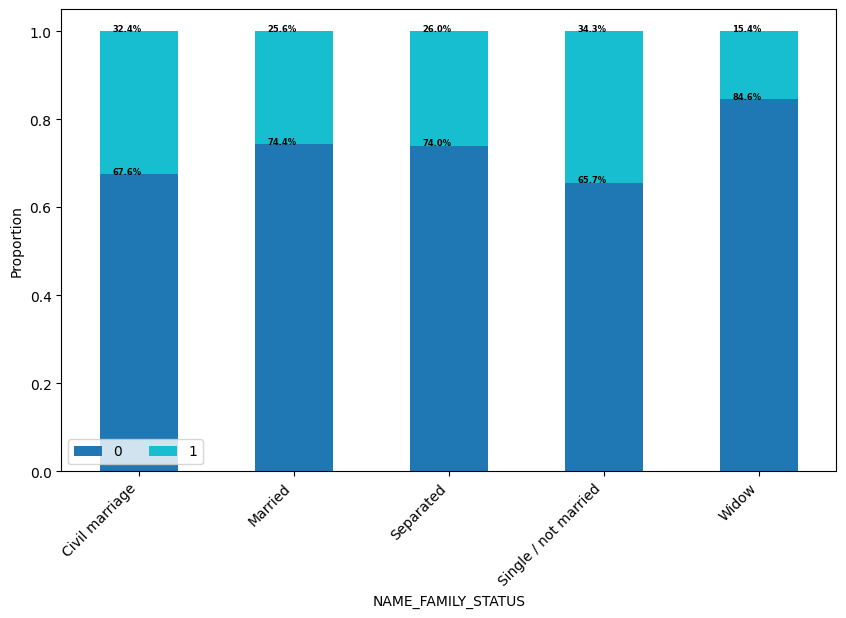

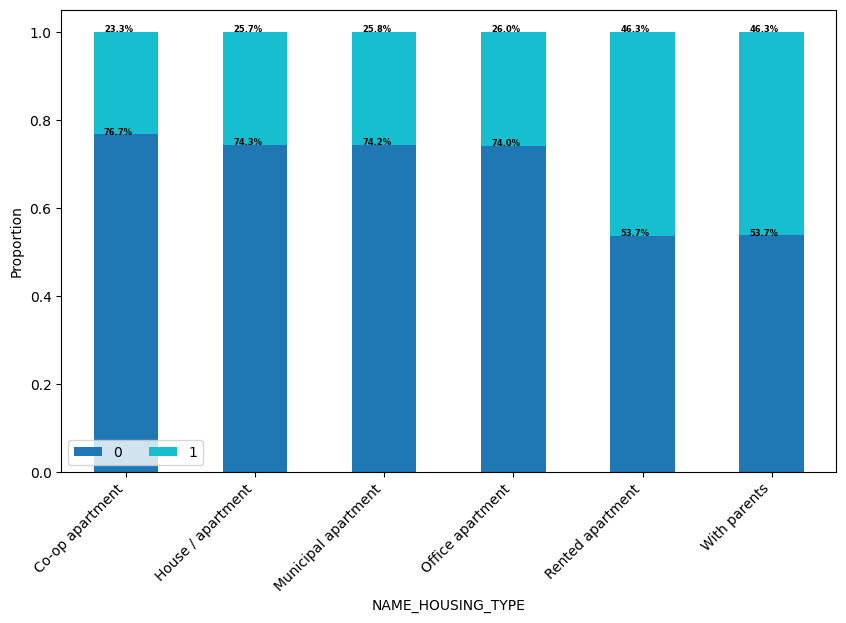

In [55]:
for col in int_cols_test:
    cross_tab_prop = pd.crosstab(index=df_test_binned[col],
                            columns=df_test_binned["TARGET"],
                                normalize="index")
    cross_tab_prop

    cross_tab = pd.crosstab(index=df_test_binned[col],
                            columns=df_test_binned["TARGET"])
    cross_tab

    cross_tab_prop.plot(kind='bar', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6))

    plt.legend(loc="lower left", ncol=2)
    plt.xlabel(str(col))
    plt.ylabel("Proportion")
    plt.xticks(rotation=45, ha='right')


    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                    cross_tab_prop.loc[x].cumsum()):
                    
            plt.text(x=n - 0.17,
                    y=y_loc,
                    s=f'{np.round(proportion * 100, 1)}%', 
                    color="black",
                    fontsize=6,
                    fontweight="bold")

    plt.savefig("PREDICTED_" + str(col), bbox_inches = "tight")
    plt.show()


 # **[#5] Comparison of a few cases, changing just 1 or 2 features**

In [56]:
sample_size = 100


In [57]:
df_test_dmatrix_subset_original = xgb.DMatrix(df_test[:sample_size].drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results_subset_original = xgb_base_model.predict(df_test_dmatrix_subset_original)
predictions_subset_original = [round(value) for value in xgb_base_test_results_subset_original]
predictions_subset_original


[0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1]

In [58]:
df_test_subset_altered = df_test[:sample_size].drop(columns='SK_ID_CURR').copy(deep = True)
df_test_subset_altered


,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,CODE_GENDER_M
256571,Cash loans,1,1,1,157500.0,770292.0,30676.5,688500.0,Family,Working,...,-105,-2876.0,-4402,19.0,Laborers,NaN,0.594327,0.427657,37.0,1.0
191493,Cash loans,0,0,0,90000.0,364896.0,19926.0,315000.0,Family,Working,...,-4930,-4654.0,-1259,NaN,Laborers,0.593554,0.619621,0.484851,49.0,0.0
103497,Cash loans,0,1,0,148500.0,284400.0,18643.5,225000.0,Unaccompanied,Working,...,-1191,-12511.0,-2474,NaN,Security staff,NaN,0.030108,0.538863,66.0,1.0
130646,Cash loans,0,0,0,188100.0,976711.5,38218.5,873000.0,Unaccompanied,Working,...,-355,-969.0,-2289,NaN,Core staff,0.628656,0.417593,0.411849,26.0,0.0
211898,Cash loans,0,1,0,180000.0,323194.5,19660.5,279000.0,Unaccompanied,Working,...,-1366,-10063.0,-1040,NaN,Laborers,NaN,0.355126,0.593718,48.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130397,Cash loans,0,1,0,90000.0,250272.0,16425.0,198000.0,Unaccompanied,Working,...,-1684,-1369.0,-1111,NaN,Medicine staff,0.427882,0.322356,NaN,48.0,0.0
157812,Cash loans,0,1,1,81000.0,900000.0,38263.5,900000.0,Family,Working,...,-1298,-4750.0,-5615,NaN,Laborers,0.591732,0.229854,NaN,45.0,0.0
47796,Cash loans,1,1,1,270000.0,720000.0,30505.5,720000.0,Unaccompanied,State servant,...,-2928,-4983.0,-3780,1.0,Managers,0.351133,0.778396,0.396220,31.0,1.0
238921,Cash loans,1,0,1,180000.0,592560.0,40216.5,450000.0,Unaccompanied,Working,...,-947,-4100.0,-2668,10.0,Medicine staff,NaN,0.579520,0.345785,27.0,0.0


In [59]:
# import random
# random.seed(22)
# for i in range(len(df_test_subset_altered)):
#     for col in int_cols_test:
#         rng = random.randint(0, len(df_test_subset_altered) - 1)
#         # print(rng)
#         df_test_subset_altered.at[df_test_subset_altered.index[i], col] = df_test_subset_altered.iloc[rng][col]
# df_test_subset_altered


In [60]:
df_test_subset_altered.dtypes


NAME_CONTRACT_TYPE            category
FLAG_OWN_CAR                     int32
FLAG_OWN_REALTY                  int32
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE               category
NAME_INCOME_TYPE              category
NAME_EDUCATION_TYPE           category
NAME_FAMILY_STATUS            category
NAME_HOUSING_TYPE             category
REGION_POPULATION_RELATIVE     float64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
OCCUPATION_TYPE               category
EXT_SOURCE_1                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_3                   float64
AGE                            float64
CODE_GENDER_M                  float64
dtype: object

In [61]:
df_test_subset_altered["NAME_FAMILY_STATUS"].describe


<bound method NDFrame.describe of 256571                 Married
191493                 Married
103497          Civil marriage
130646    Single / not married
211898          Civil marriage
                  ...         
130397                 Married
157812                 Married
47796                  Married
238921                 Married
206875                 Married
Name: NAME_FAMILY_STATUS, Length: 100, dtype: category
Categories (6, object): ['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Unknown', 'Widow']>

In [62]:
for i in range(len(df_test_subset_altered)):
    df_test_subset_altered.at[df_test_subset_altered.index[i], "NAME_EDUCATION_TYPE"] = "Lower secondary"
    df_test_subset_altered.at[df_test_subset_altered.index[i], "NAME_FAMILY_STATUS"] = "Single / not married"    
    if i % 2 == 0:
        df_test_subset_altered.at[df_test_subset_altered.index[i], "CODE_GENDER_M"] = 1
        df_test_subset_altered.at[df_test_subset_altered.index[i], "NAME_INCOME_TYPE"] = "Unemployed"
    else:
        df_test_subset_altered.at[df_test_subset_altered.index[i], "CODE_GENDER_M"] = 0
        df_test_subset_altered.at[df_test_subset_altered.index[i], "NAME_INCOME_TYPE"] = "Maternity leave"
        
df_test_subset_altered


,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE,CODE_GENDER_M
256571,Cash loans,1,1,1,157500.0,770292.0,30676.5,688500.0,Family,Unemployed,...,-105,-2876.0,-4402,19.0,Laborers,NaN,0.594327,0.427657,37.0,1.0
191493,Cash loans,0,0,0,90000.0,364896.0,19926.0,315000.0,Family,Maternity leave,...,-4930,-4654.0,-1259,NaN,Laborers,0.593554,0.619621,0.484851,49.0,0.0
103497,Cash loans,0,1,0,148500.0,284400.0,18643.5,225000.0,Unaccompanied,Unemployed,...,-1191,-12511.0,-2474,NaN,Security staff,NaN,0.030108,0.538863,66.0,1.0
130646,Cash loans,0,0,0,188100.0,976711.5,38218.5,873000.0,Unaccompanied,Maternity leave,...,-355,-969.0,-2289,NaN,Core staff,0.628656,0.417593,0.411849,26.0,0.0
211898,Cash loans,0,1,0,180000.0,323194.5,19660.5,279000.0,Unaccompanied,Unemployed,...,-1366,-10063.0,-1040,NaN,Laborers,NaN,0.355126,0.593718,48.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130397,Cash loans,0,1,0,90000.0,250272.0,16425.0,198000.0,Unaccompanied,Maternity leave,...,-1684,-1369.0,-1111,NaN,Medicine staff,0.427882,0.322356,NaN,48.0,0.0
157812,Cash loans,0,1,1,81000.0,900000.0,38263.5,900000.0,Family,Unemployed,...,-1298,-4750.0,-5615,NaN,Laborers,0.591732,0.229854,NaN,45.0,1.0
47796,Cash loans,1,1,1,270000.0,720000.0,30505.5,720000.0,Unaccompanied,Maternity leave,...,-2928,-4983.0,-3780,1.0,Managers,0.351133,0.778396,0.396220,31.0,0.0
238921,Cash loans,1,0,1,180000.0,592560.0,40216.5,450000.0,Unaccompanied,Unemployed,...,-947,-4100.0,-2668,10.0,Medicine staff,NaN,0.579520,0.345785,27.0,1.0


In [63]:
df_test_dmatrix_subset_altered = xgb.DMatrix(df_test_subset_altered, enable_categorical=True)
xgb_base_test_results_subset_altered = xgb_base_model.predict(df_test_dmatrix_subset_altered)
predictions_subset_altered = [round(value) for value in xgb_base_test_results_subset_altered]
predictions_subset_altered


[1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1]

In [64]:
print(predictions_subset_original, predictions_subset_altered, sep = "\n")


[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
[1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1]


In [65]:
# diff = 0
# for i in range(len(predictions_subset_altered)):
#     diff += abs(int(predictions_subset_altered[i]) - int(predictions_subset_original[i]))


# print("Difference: %.2f%%" % (diff / sample_size * 100))


In [66]:
diff = sum(predictions_subset_altered) - sum(predictions_subset_original)

print("Difference: %.2f%%" % (diff / sample_size * 100))


Difference: 9.00%


 # **[#6] Wrap up: characteristics of the training dataset and how a ML model learns them**

 # **[#7] Dropping all our concerns**


In [67]:
ap_train_unbiased.drop(columns=int_cols, inplace = True)

In [68]:
ap_train_unbiased['FLAG_OWN_CAR'] = np.where(ap_train_unbiased['FLAG_OWN_CAR'] == 'Y', 1, 0)
ap_train_unbiased['FLAG_OWN_REALTY'] = np.where(ap_train_unbiased['FLAG_OWN_REALTY'] == 'Y', 1, 0)

In [69]:
ap_objects_unbiased = list(ap_train_unbiased.select_dtypes(include=['object']).columns)
ap_train_unbiased[ap_objects_unbiased] = ap_train_unbiased[ap_objects_unbiased].astype('category')

 Let's separate the target from the rest of the data

In [70]:
ap_train_target_unbiased = ap_train_unbiased.pop('TARGET')
print(f"Target unbiased dataset shape: {ap_train_target_unbiased.shape}")

Target unbiased dataset shape: (307511,)


 Let's split the original dataset in two:

 *   80% for the train dataset
 *   20% for the test one



In [71]:
df_train_unbiased, df_test_unbiased, df_target_train_unbiased, df_target_test_unbiased = train_test_split(
    ap_train_unbiased, ap_train_target_unbiased, test_size=0.2, stratify=ap_train_target_unbiased, random_state=42)

print(f"Train unbiased dataset shape: {df_train_unbiased.shape}")
print(f"Test unbiased dataset shape: {df_test_unbiased.shape}")

Train unbiased dataset shape: (246008, 17)
Test unbiased dataset shape: (61503, 17)


In [72]:
df_train_unbiased.dtypes

SK_ID_CURR                       int64
NAME_CONTRACT_TYPE            category
FLAG_OWN_CAR                     int32
FLAG_OWN_REALTY                  int32
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE               category
REGION_POPULATION_RELATIVE     float64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
OCCUPATION_TYPE               category
EXT_SOURCE_1                   float64
EXT_SOURCE_2                   float64
EXT_SOURCE_3                   float64
dtype: object

In [73]:
cat_cols = []
for col in df_train_unbiased.columns:
    if df_train_unbiased[col].dtype == "category":
        cat_cols.append(col)
cat_cols


['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE']

In [74]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()

for col in cat_cols:
    df_train_unbiased[col] = lbl.fit_transform(df_train_unbiased[col].astype(str))


 # Create a basic ML model and scoring on the test set

 I'll train a simple XGBoost model (parameters previously chosen with cross-validation).

In [75]:
df_train_dmatrix_unbiased = xgb.DMatrix(df_train_unbiased.drop(columns='SK_ID_CURR'), label = df_target_train_unbiased, enable_categorical=True)

params = {'max_depth':6,
         'eta':.2,
         'subsample':.9,
         'colsample_bytree':.9,
         'scale_pos_weight':10,
         'objective':'binary:logistic',
         'tree_method':'exact'}
xgb_base_model_unbiased = xgb.train(params, df_train_dmatrix_unbiased, num_boost_round=50)


 Let's score the test set.

In [76]:
df_test_dmatrix_unbiased = xgb.DMatrix(df_test_unbiased.drop(columns='SK_ID_CURR'), enable_categorical=True)
xgb_base_test_results_unbiased = xgb_base_model_unbiased.predict(df_test_dmatrix_unbiased)


 What are the risk scores (from 0 to 1) of the first 5 customers in the test set? And what's the overall AUC on the test set?

In [77]:
xgb_base_test_results_unbiased[:5]


array([0.41405448, 0.2634759 , 0.7225189 , 0.3854774 , 0.49003527],
      dtype=float32)

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(df_target_test_unbiased, xgb_base_test_results_unbiased, pos_label=1)
metrics.auc(fpr, tpr)


0.7373679964356246

 The third customer has a higher risk score (0.722) than the others in the first 5 records.

 This simple model has an AUC on the test set around **0.737**, a decent baseline performance.

 # **[#8] A closer look at the performance without features of ethical concern**

 # **[#9] Wrapping up again: what happens by just removing the features of concern**

 # **[#10] Hints at a possible (but questionable!) solution**